In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


***Define Network***
三步驟是：繼承 Module class、overwrite __init__()、 和 overwrite forward()：

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 32, 3)
        self.dropout = nn.Dropout2d(0.25)
        self.fc = nn.Linear(5408, 10)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

**Training**

In [ ]:


def train(model, train_loader, optimizer, epochs, log_interval):
    model.train()
    losses = [] # to store losses
    for epoch in range(1, epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Clear gradient
            optimizer.zero_grad()

            # Forward propagation
            output = model(data)

            # Negative log likelihood loss (log prob + nll loss = prob + cross entropy loss)
            loss = F.nll_loss(output, target)

            # Back propagation
            loss.backward()

            # Parameter update
            optimizer.step()

            # Log training info
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                losses.append(loss.item()) # append current loss

    # plot the losses
    plt.figure()
    plt.plot(losses)
    plt.title('Training loss over time')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()


因為 training 和 testing 時 model 會有不同行為，所以用 model.train() 把 model 調成 training 模式。

接著 iterate 過 epoch，每個 epoch 會 train 過整個 training set。每個 dataset 會做 batch training。

接下來就是重點了。基本的步驟：clear gradient、feed data forward、取 loss、back propagation 算 gradient、最後 update parameter。

每隔幾個 batch 就會 log 一次現在的 loss 和進度，方便查看和分析。

**Testing**

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in test_loader:
            # Prediction
            output = model(data)

            # Compute loss & accuracy
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct

    test_loss /= len(test_loader.dataset)

    # Log testing info
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

with torch.no_grad() 包起來的部分，PyTorch 負責 gradient 的 engine 就會進行優化

**Data Loading, Training, Testing**

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.271662
Train Epoch: 1 [64/60000 (0%)]	Loss: 1.927220
Train Epoch: 1 [128/60000 (0%)]	Loss: 1.939872
Train Epoch: 1 [192/60000 (0%)]	Loss: 1.440209
Train Epoch: 1 [256/60000 (0%)]	Loss: 1.442631
Train Epoch: 1 [320/60000 (1%)]	Loss: 1.217667
Train Epoch: 1 [384/60000 (1%)]	Loss: 1.017438
Train Epoch: 1 [448/60000 (1%)]	Loss: 1.133701
Train Epoch: 1 [512/60000 (1%)]	Loss: 1.048094
Train Epoch: 1 [576/60000 (1%)]	Loss: 1.193837
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.944830
Train Epoch: 1 [704/60000 (1%)]	Loss: 0.785651
Train Epoch: 1 [768/60000 (1%)]	Loss: 0.698956
Train Epoch: 1 [832/60000 (1%)]	Loss: 0.793351
Train Epoch: 1 [896/60000 (1%)]	Loss: 0.774457
Train Epoch: 1 [960/60000 (2%)]	Loss: 0.596410
Train Epoch: 1 [1024/60000 (2%)]	Loss: 0.783342
Train Epoch: 1 [1088/60000 (2%)]	Loss: 0.761052
Train Epoch: 1 [1152/60000 (2%)]	Loss: 0.430812
Train Epoch: 1 [1216/60000 (2%)]	Loss: 0.828869
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.480091
Train Epoch

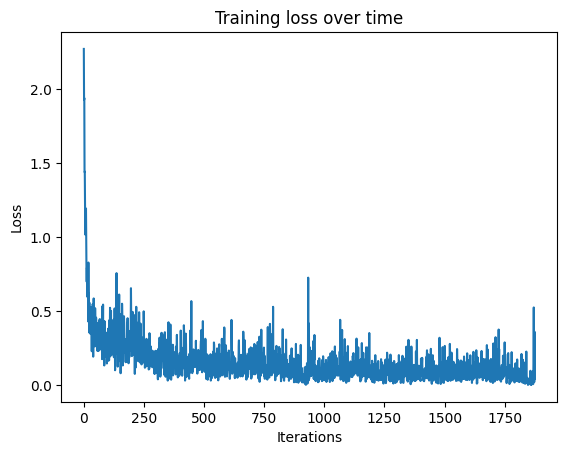


Test set: Average loss: 0.0705, Accuracy: 9775/10000 (98%)



In [ ]:
def main():
    # Training settings
    BATCH_SIZE = 64
    EPOCHS = 2
    LOG_INTERVAL = 1

    # Define image transform
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # mean and std for the MNIST training set
    ])

    # Load dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
    test_dataset = datasets.MNIST('./data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Create network & optimizer
    model = Net()
    optimizer = optim.Adam(model.parameters())

    # Train
    train(model, train_loader, optimizer, EPOCHS, LOG_INTERVAL)

    # Save and load model
    torch.save(model.state_dict(), "mnist_cnn.pt")
    model = Net()
    model.load_state_dict(torch.load("mnist_cnn.pt"))

    # Test
    test(model, test_loader)

if __name__ == '__main__':
    main()

Data loader 的部分，會先用 torchvision.transforms 這個 package 提供的工具，把 dataset 的 data 做 pre-processing。能做的事包括包成 tensor、resize、crop、normalization 等等。這邊我們做包成 tensor 和 normalization。

再來 PyTorch 有提供寫好的 MNIST Dataset class，我們就不用自己下載 dataset、load file、建立 Dataset class 了。如果要用自己的 dataset 就要自己處理了。